# Conceptular Synthesis Experiment 1.2: Snare and Bongo combined model

In [4]:
%pylab inline
from IPython.display import Audio
import librosa
import scipy as sp
figsize(20,6)

Populating the interactive namespace from numpy and matplotlib


In [5]:

def nrmse(output,target):
    combinedVar = 0.5 * (np.var(target, ddof=1) + np.var(output, ddof=1))
    errorSignal = output - target
    return np.sqrt(np.mean(errorSignal ** 2) / combinedVar)

def generateInternalWeights(nInternalUnits, connectivity):
    success = False
    internalWeights = 0
    while success == False:
        try:
            internalWeights = np.random.randn(nInternalUnits,nInternalUnits) * (np.random.random((nInternalUnits,nInternalUnits)) < connectivity)
            specRad = abs(np.linalg.eig(internalWeights)[0][0])
            if (specRad > 0):
                internalWeights = internalWeights / specRad
                success = True
        except e:
            print(e)
    return internalWeights

pLoop = lambda n,p: p[n%p.size]

In [6]:
y, sr = librosa.load("audios/bongo6.wav", sr=22050)
y = y[40:]
windowSize =15
padding = windowSize - (y.size % windowSize)
y = np.concatenate((y, np.zeros(padding)))
nWindows = int(y.size/windowSize)
print(y.shape, nWindows)

(2685,) 179


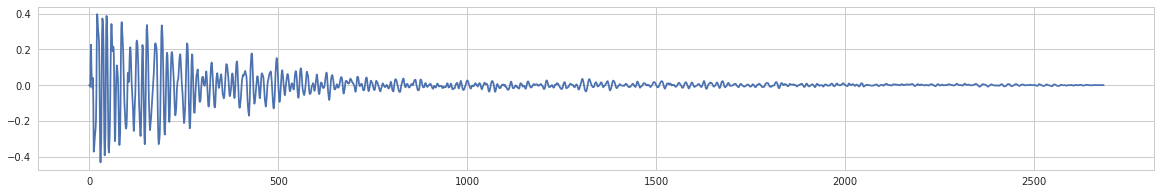

In [7]:
import seaborn as sns
sns.set(style="whitegrid")
figsize(20,3)
plot(y)

In [8]:
Audio(data=y[:],rate=sr)

In [9]:
y2, sr2 = librosa.load("audios/snare.wav", sr=22050)
y2 = y2[20:]
padding2 = windowSize - (y2.size % windowSize)
y2 = np.concatenate((y2, np.zeros(padding2)))
nWindows2 = int(y2.size/windowSize)
print(y2.shape, nWindows2)

(3300,) 220


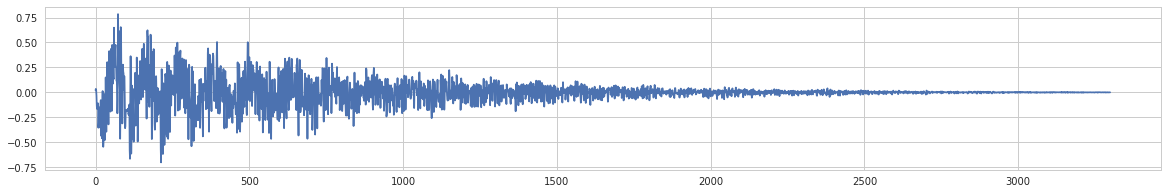

In [10]:
import seaborn as sns
sns.set(style="whitegrid")
figsize(20,3)
plot(y2)

In [11]:
Audio(data=y2[:],rate=sr2)

In [12]:
#divide out windows
patterns = np.zeros((nWindows, windowSize))
for i in range(nWindows):
    patterns[i] = y[i*windowSize : (i+1) * windowSize]
patterns2 = np.zeros((nWindows2, windowSize))
for i in range(nWindows2):
    patterns2[i] = y2[i*windowSize : (i+1) * windowSize]

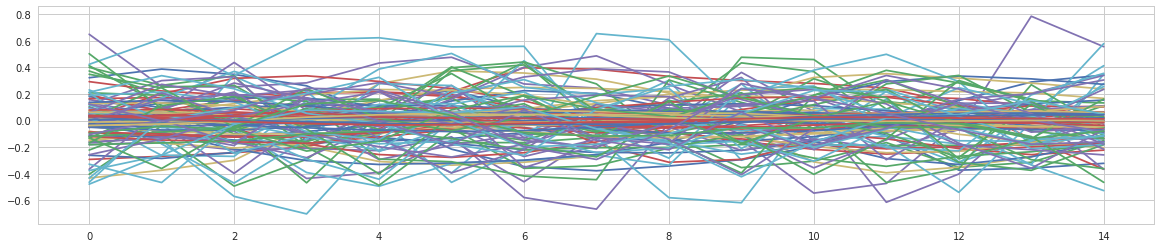

In [13]:
figsize(20,4)
# for i in range(int(nWindows)):
for i in range(int(50)):
    plot(patterns[i])
    plot(patterns2[i])    

In [11]:
np.concatenate((patterns[:2], patterns2[:2]),axis=0)

array([[-0.00076294, -0.0015564 ,  0.00097656, -0.00949097,  0.14849854,
         0.22616577,  0.09487915,  0.03424072,  0.03701782, -0.0173645 ,
         0.0397644 , -0.11141968, -0.37277222, -0.3581543 , -0.32165527],
       [-0.29232788, -0.26861572, -0.24279785, -0.19628906, -0.06304932,
         0.21591187,  0.39697266,  0.38562012,  0.33206177,  0.30059814,
         0.27908325,  0.24490356,  0.12280273, -0.13702393, -0.36566162],
       [ 0.02166304,  0.03490198,  0.02175767, -0.03340608, -0.13782068,
        -0.16673383, -0.16554233, -0.127049  , -0.10938299, -0.35396749,
        -0.30486479, -0.16573872, -0.35145301, -0.31344935, -0.15075555],
       [-0.15835416, -0.13579004, -0.07830386, -0.43531427, -0.38974908,
        -0.14785144, -0.46033815, -0.10536114,  0.01277046, -0.14894617,
        -0.54554808, -0.47271883, -0.01558029, -0.13145055, -0.13679676]])

In [12]:
%%time
#create a random reservoir and load it with patterns using Jaeger's method
def makeLoadedNetwork_v2(p):
    Netconnectivity = 1
    if p['N'] > 20:
        Netconnectivity = 10.0/p['N'];
    WstarRaw = generateInternalWeights(p['N'], Netconnectivity)
    WinRaw = 2 * (np.random.rand(p['N'], 1) - 0.5)
    WbiasRaw = 2 * (np.random.rand(p['N'], 1) - 0.5)

    #Scale raw weights     
    Wstar = p['NetSR'] * WstarRaw;
    Win = p['NetinpScaling'] * WinRaw;
    Wbias = p['BiasScaling'] * WbiasRaw;  
    I = np.eye(p['N'])
    x = np.zeros((p['N'],1))
    
    allTrainxArgs = np.zeros((p['N'] + 1, p['learnLength'] * p['patts'].shape[0]));
    allTrainOldxArgs = np.zeros((p['N'], p['learnLength'] * p['patts'].shape[0]));
    allTrainWtargets = np.zeros((p['N'], p['learnLength'] * p['patts'].shape[0]));
    allTrainOuts = np.zeros((1, p['learnLength'] * p['patts'].shape[0]));
    patternRs =  np.zeros((1, p['patts'].shape[0]), dtype=np.object)
    print('Loading patterns: ', end='')
    for i_pattern in range(p['patts'].shape[0]):
        print(i_pattern, " ", end='')
        patt = p['patts'][i_pattern]
        xCollector = np.zeros((p['N'] + 1, p['learnLength']));
        xOldCollector = np.zeros((p['N'], p['learnLength']));
        WTargetCollector = np.zeros((p['N'], p['learnLength']));
        pCollector = np.zeros((1, p['learnLength']));
        x = np.zeros((p['N'], 1));

        for n in range(p['washoutLength'] + p['learnLength']):
            u = patt.take(n, mode='wrap')
            xOld = x
            Wtarget = (Wstar.dot(x)) + (Win.dot(u))
            x = ((1.0-p['LR']) * xOld) + (p['LR'] * tanh(Wtarget + Wbias))
            if n >= p['washoutLength']:
                xCollector[:, n - p['washoutLength']] = np.concatenate((x[:,0], np.array([1])))
                xOldCollector[:, n - p['washoutLength']] = xOld[:,0]
                WTargetCollector[:, n - p['washoutLength']] = Wtarget[:,0]
                pCollector[0, n - p['washoutLength']] = u
            uOld = u
        
        R = xCollector[0:-1].dot(xCollector[0:-1].T) / p['learnLength']
        storeBegin = i_pattern * p['learnLength']
        storeEnd = (i_pattern * p['learnLength']) + p['learnLength']
        patternRs[0,i_pattern] = R
        allTrainxArgs[:,storeBegin : storeEnd ] = xCollector
        allTrainOldxArgs[:,storeBegin : storeEnd ] = xOldCollector
        allTrainOuts[:,storeBegin : storeEnd ] = pCollector
        allTrainWtargets[:,storeBegin : storeEnd ]  = WTargetCollector


    Wout = (linalg.inv(allTrainxArgs.dot(allTrainxArgs.conj().T) +
                      (p['TychonovAlphaReadout'] * np.eye(p['N'] + 1))).dot(allTrainxArgs).dot(allTrainOuts.conj().T)).conj().T

    outsRecovered = Wout.dot(allTrainxArgs);
    NRMSE_readout = mean(nrmse(outsRecovered, allTrainOuts))
    absSize_readout = mean(mean(abs(Wout), axis=0))
    print("\nNRMSE readout: ", NRMSE_readout, " :: ", end='')
    print("absSize readout: ", absSize_readout)
    
    W = (linalg.inv(allTrainOldxArgs.dot(allTrainOldxArgs.conj().T) +
                      (p['TychonovAlpha'] * np.eye(p['N']))).dot(allTrainOldxArgs).dot(allTrainWtargets.conj().T)).conj().T
    NRMSE_W = mean(nrmse(W.dot(allTrainOldxArgs), allTrainWtargets))
    absSize_W = mean(mean(abs(W), axis=0))
    print("NRMSE W: ", NRMSE_W, " :: ", end='')
    print("absSize W: ", absSize_W)

    data ={k: v for k, v in locals().items() if k in 
           ('p','Win','Wstar', 'Wbias','NRMSE_W', 'absSize_W','patternRs','W',
            'Wout', 'allTrainOldxArgs','NRMSE_readout', 'absSize_readout')}
    return data

    


    
params = {'N':800, 'NetSR':1.5, 'NetinpScaling':1.2,'BiasScaling':0.5,'TychonovAlpha':0.0001,
         'washoutLength':windowSize*4, 'learnLength':windowSize * 4, 'TychonovAlphaReadout':0.001,
          'LR': 0.99,
           'patts':np.concatenate((patterns[:100], patterns2[:100]),axis=0)
#           'patts':patterns
         }



sampleSize = 15
loadedNets = np.zeros(sampleSize, dtype=np.object)
for i_net, net in enumerate(loadedNets):
    print(i_net)
    loadedNets[i_net] = makeLoadedNetwork_v2(params)
nrmses = [x['NRMSE_readout'] for x in loadedNets]
bestNetwork = np.argmin(nrmses)
print("NRMSEs: best: ", loadedNets[bestNetwork]['NRMSE_readout'], "avg: ", np.mean(nrmses) )



0
Loading patterns: 0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99  100  101  102  103  104  105  106  107  108  109  110  111  112  113  114  115  116  117  118  119  120  121  122  123  124  125  126  127  128  129  130  131  132  133  134  135  136  137  138  139  140  141  142  143  144  145  146  147  148  149  150  151  152  153  154  155  156  157  158  159  160  161  162  163  164  165  166  167  168  169  170  171  172  173  174  175  176  177  178  179  180  181  182  183  184  185  186  187  188  189  190  191  192  193  194  195  196  197  198  199  
NRMSE readout:  0.0256636923325  :: absSize readout:  0.00338096902959
NRMSE W:  0.039828

NRMSE W:  0.0501897418437  :: absSize W:  0.0129353662722
8
Loading patterns: 0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99  100  101  102  103  104  105  106  107  108  109  110  111  112  113  114  115  116  117  118  119  120  121  122  123  124  125  126  127  128  129  130  131  132  133  134  135  136  137  138  139  140  141  142  143  144  145  146  147  148  149  150  151  152  153  154  155  156  157  158  159  160  161  162  163  164  165  166  167  168  169  170  171  172  173  174  175  176  177  178  179  180  181  182  183  184  185  186  187  188  189  190  191  192  193  194  195  196  197  198  199  
NRMSE readout:  0.0102812782889

In [14]:
def computeConceptor(net, i_pattern, alpha):
    print('Computing conceptor, alpha: ', alpha)
    Cs = np.zeros(4, dtype=np.object)
    R = net['patternRs'][0,i_pattern]
    [U,s,V] = svd(R)
    S = diag(s)
    Snew = S.dot(linalg.inv(S + pow(alpha, -2) * np.eye(net['p']['N'])))

    C =  U.dot(Snew).dot(U.T);
    Cs[0] = C
    Cs[1] = U
    Cs[2] = diag(Snew)
    Cs[3] = diag(S)

    return Cs


def testConceptor(net, cs, recallTestLength):
    trials = 1
    attens = np.zeros(trials)
    C = cs[0]
    for i_trial in range(trials):
        x_CTestPL = np.zeros((net['p']['N'], recallTestLength))
        z_CTestPL = np.zeros((net['p']['N'], recallTestLength))
        x = 0.5 * np.random.randn(net['p']['N'],1) * 0.0
        z = x
        for n in range(recallTestLength + net['p']['washoutLength']):
            xOld = x
            Wtarget = (net['W'].dot(x))
            z = ((1.0-net['p']['LR']) * xOld) + (net['p']['LR'] * tanh(Wtarget + net['Wbias']))
            x = C.dot(z)
            xPrev = x
            if (n > net['p']['washoutLength']):
                x_CTestPL[:,n-net['p']['washoutLength']] = x.T
                z_CTestPL[:,n-net['p']['washoutLength']] = z.T

        attenuation = np.mean(pow(np.linalg.norm(z_CTestPL[:,:] - x_CTestPL[:,:], axis=1),2)) / np.mean(pow(np.linalg.norm(z_CTestPL[:,:], axis=1),2))
        attens[i_trial] = attenuation
        
    return np.mean(attens)



In [15]:
%%time
import scipy
def fitnessf(aperture, *args):
    print('Pattern: ', args[0])
    cs = computeConceptor(loadedNets[bestNetwork], args[0], aperture)
    atten = testConceptor(loadedNets[bestNetwork], cs, windowSize*4)
    return atten

apertures = [scipy.optimize.fminbound(fitnessf, 0,1000,  disp=3, xtol=1, args = (x,)) 
             for x in np.arange(params['patts'].shape[0])]

Pattern:  0
Computing conceptor, alpha:  381.96601125
 
 Func-count     x          f(x)          Procedure
    1        381.966   0.00159495        initial
Pattern:  0
Computing conceptor, alpha:  618.03398875
    2        618.034   0.00159847        golden
Pattern:  0
Computing conceptor, alpha:  236.0679775
    3        236.068   0.00158584        golden
Pattern:  0
Computing conceptor, alpha:  145.89803375
    4        145.898   0.00156275        golden
Pattern:  0
Computing conceptor, alpha:  90.1699437495
    5        90.1699   0.00150703        golden
Pattern:  0
Computing conceptor, alpha:  55.7280900008
    6        55.7281     0.001389        golden
Pattern:  0
Computing conceptor, alpha:  34.4418537486
    7        34.4419   0.00120905        golden
Pattern:  0
Computing conceptor, alpha:  21.2862362522
    8        21.2862   0.00112468        golden
Pattern:  0
Computing conceptor, alpha:  13.1556174964
    9        13.1556   0.00174538        golden
Pattern:  0
Computing co

 
 Func-count     x          f(x)          Procedure
    1        381.966  0.000834057        initial
Pattern:  5
Computing conceptor, alpha:  618.03398875
    2        618.034  0.000838373        golden
Pattern:  5
Computing conceptor, alpha:  236.0679775
    3        236.068  0.000823144        golden
Pattern:  5
Computing conceptor, alpha:  145.89803375
    4        145.898  0.000797141        golden
Pattern:  5
Computing conceptor, alpha:  90.1699437495
    5        90.1699  0.000745359        golden
Pattern:  5
Computing conceptor, alpha:  55.7280900008
    6        55.7281  0.000692814        golden
Pattern:  5
Computing conceptor, alpha:  34.4418537486
    7        34.4419  0.000737965        golden
Pattern:  5
Computing conceptor, alpha:  61.2921203929
    8        61.2921  0.000698569        parabolic
Pattern:  5
Computing conceptor, alpha:  54.1093115558
    9        54.1093  0.000691928        parabolic
Pattern:  5
Computing conceptor, alpha:  46.5970111457
   10         46.

 
 Func-count     x          f(x)          Procedure
    1        381.966   0.00027289        initial
Pattern:  10
Computing conceptor, alpha:  618.03398875
    2        618.034  0.000273368        golden
Pattern:  10
Computing conceptor, alpha:  236.0679775
    3        236.068   0.00027166        golden
Pattern:  10
Computing conceptor, alpha:  145.89803375
    4        145.898   0.00026859        golden
Pattern:  10
Computing conceptor, alpha:  90.1699437495
    5        90.1699  0.000261458        golden
Pattern:  10
Computing conceptor, alpha:  55.7280900008
    6        55.7281  0.000247433        golden
Pattern:  10
Computing conceptor, alpha:  34.4418537486
    7        34.4419  0.000228301        golden
Pattern:  10
Computing conceptor, alpha:  21.2862362522
    8        21.2862  0.000220257        golden
Pattern:  10
Computing conceptor, alpha:  13.1556174964
    9        13.1556  0.000266045        golden
Pattern:  10
Computing conceptor, alpha:  26.3112349928
   10        2

   15        12.1125  0.000372706        parabolic

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  15
Computing conceptor, alpha:  381.96601125
 
 Func-count     x          f(x)          Procedure
    1        381.966  0.000305361        initial
Pattern:  15
Computing conceptor, alpha:  618.03398875
    2        618.034  0.000305268        golden
Pattern:  15
Computing conceptor, alpha:  763.9320225
    3        763.932  0.000305248        golden
Pattern:  15
Computing conceptor, alpha:  790.705964964
    4        790.706  0.000305245        parabolic
Pattern:  15
Computing conceptor, alpha:  870.649172705
    5        870.649  0.000305239        golden
Pattern:  15
Computing conceptor, alpha:  920.056792259
    6        920.057  0.000305236        golden
Pattern:  15
Computing conceptor, alpha:  950.592380446
    7        950.592  0.000305235        golden
Pattern:  15
Computing conceptor, alpha:  969.464411813


   11         993.12  0.000166601        golden
Pattern:  19
Computing conceptor, alpha:  995.747737052
   12        995.748  0.000166601        golden
Pattern:  19
Computing conceptor, alpha:  997.371956969
   13        997.372  0.000166601        golden
Pattern:  19
Computing conceptor, alpha:  998.375780083
   14        998.376  0.000166601        golden
Pattern:  19
Computing conceptor, alpha:  998.996176886
   15        998.996    0.0001666        golden
Pattern:  19
Computing conceptor, alpha:  999.379603197
   16         999.38    0.0001666        golden

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  20
Computing conceptor, alpha:  381.96601125
 
 Func-count     x          f(x)          Procedure
    1        381.966  0.000108527        initial
Pattern:  20
Computing conceptor, alpha:  618.03398875
    2        618.034  0.000116182        golden
Pattern:  20
Computing conceptor, alpha:  236.0679775
    3 

   12        15.9279  0.000137964        parabolic
Pattern:  24
Computing conceptor, alpha:  15.4894013175
   13        15.4894  0.000137834        parabolic
Pattern:  24
Computing conceptor, alpha:  14.5979752202
   14         14.598  0.000138041        golden
Pattern:  24
Computing conceptor, alpha:  15.1560677544
   15        15.1561  0.000137829        parabolic

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  25
Computing conceptor, alpha:  381.96601125
 
 Func-count     x          f(x)          Procedure
    1        381.966  0.000112545        initial
Pattern:  25
Computing conceptor, alpha:  618.03398875
    2        618.034  0.000113566        golden
Pattern:  25
Computing conceptor, alpha:  236.0679775
    3        236.068  0.000110013        golden
Pattern:  25
Computing conceptor, alpha:  145.89803375
    4        145.898  0.000104227        golden
Pattern:  25
Computing conceptor, alpha:  90.169943749

   14        997.326    1.211e-05        golden
Pattern:  29
Computing conceptor, alpha:  998.347507622
   15        998.348    1.211e-05        golden
Pattern:  29
Computing conceptor, alpha:  998.978703544
   16        998.979    1.211e-05        golden
Pattern:  29
Computing conceptor, alpha:  999.368804078
   17        999.369    1.211e-05        golden

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  30
Computing conceptor, alpha:  381.96601125
 
 Func-count     x          f(x)          Procedure
    1        381.966  7.44115e-05        initial
Pattern:  30
Computing conceptor, alpha:  618.03398875
    2        618.034   7.5761e-05        golden
Pattern:  30
Computing conceptor, alpha:  236.0679775
    3        236.068  7.14024e-05        golden
Pattern:  30
Computing conceptor, alpha:  145.89803375
    4        145.898  6.61519e-05        golden
Pattern:  30
Computing conceptor, alpha:  90.1699437495
    5  

 
 Func-count     x          f(x)          Procedure
    1        381.966   3.1703e-05        initial
Pattern:  35
Computing conceptor, alpha:  618.03398875
    2        618.034  3.60802e-05        golden
Pattern:  35
Computing conceptor, alpha:  236.0679775
    3        236.068  2.36148e-05        golden
Pattern:  35
Computing conceptor, alpha:  145.89803375
    4        145.898  1.35733e-05        golden
Pattern:  35
Computing conceptor, alpha:  90.1699437495
    5        90.1699  7.38621e-06        golden
Pattern:  35
Computing conceptor, alpha:  55.7280900008
    6        55.7281  7.56712e-06        golden
Pattern:  35
Computing conceptor, alpha:  74.9856782713
    7        74.9857  6.85562e-06        parabolic
Pattern:  35
Computing conceptor, alpha:  74.2072649763
    8        74.2073  6.85311e-06        parabolic
Pattern:  35
Computing conceptor, alpha:  73.7868936374
    9        73.7869  6.85284e-06        parabolic
Pattern:  35
Computing conceptor, alpha:  73.4535592096
   10

    7        138.688  8.28015e-06        parabolic
Pattern:  40
Computing conceptor, alpha:  120.155868572
    8        120.156  8.47255e-06        golden
Pattern:  40
Computing conceptor, alpha:  135.508734536
    9        135.509  8.26826e-06        parabolic
Pattern:  40
Computing conceptor, alpha:  134.620432254
   10         134.62  8.26792e-06        parabolic
Pattern:  40
Computing conceptor, alpha:  134.953767585
   11        134.954  8.26789e-06        parabolic

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  41
Computing conceptor, alpha:  381.96601125
 
 Func-count     x          f(x)          Procedure
    1        381.966   6.1026e-05        initial
Pattern:  41
Computing conceptor, alpha:  618.03398875
    2        618.034  6.63387e-05        golden
Pattern:  41
Computing conceptor, alpha:  236.0679775
    3        236.068  5.02956e-05        golden
Pattern:  41
Computing conceptor, alpha:  145.8980

    7        34.4419  4.57272e-06        golden
Pattern:  46
Computing conceptor, alpha:  43.1204183951
    8        43.1204  4.34727e-06        parabolic
Pattern:  46
Computing conceptor, alpha:  43.453752368
    9        43.4538  4.34749e-06        parabolic
Pattern:  46
Computing conceptor, alpha:  42.7870844222
   10        42.7871  4.34768e-06        parabolic

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  47
Computing conceptor, alpha:  381.96601125
 
 Func-count     x          f(x)          Procedure
    1        381.966  8.98419e-06        initial
Pattern:  47
Computing conceptor, alpha:  618.03398875
    2        618.034   9.2572e-06        golden
Pattern:  47
Computing conceptor, alpha:  236.0679775
    3        236.068  8.57687e-06        golden
Pattern:  47
Computing conceptor, alpha:  145.89803375
    4        145.898  8.21584e-06        golden
Pattern:  47
Computing conceptor, alpha:  90.1699437495

 
 Func-count     x          f(x)          Procedure
    1        381.966  4.29914e-05        initial
Pattern:  53
Computing conceptor, alpha:  618.03398875
    2        618.034  4.81827e-05        golden
Pattern:  53
Computing conceptor, alpha:  236.0679775
    3        236.068  3.33787e-05        golden
Pattern:  53
Computing conceptor, alpha:  145.89803375
    4        145.898  1.97809e-05        golden
Pattern:  53
Computing conceptor, alpha:  90.1699437495
    5        90.1699  9.62479e-06        golden
Pattern:  53
Computing conceptor, alpha:  55.7280900008
    6        55.7281   6.2644e-06        golden
Pattern:  53
Computing conceptor, alpha:  21.0005861557
    7        21.0006  7.05604e-06        parabolic
Pattern:  53
Computing conceptor, alpha:  44.9144297546
    8        44.9144  5.46824e-06        parabolic
Pattern:  53
Computing conceptor, alpha:  41.1912157186
    9        41.1912  5.30104e-06        parabolic
Pattern:  53
Computing conceptor, alpha:  33.4790814798
   10

    5        90.1699  2.06725e-06        golden
Pattern:  59
Computing conceptor, alpha:  55.7280900008
    6        55.7281  1.85724e-06        golden
Pattern:  59
Computing conceptor, alpha:  34.4418537486
    7        34.4419  1.93674e-06        golden
Pattern:  59
Computing conceptor, alpha:  55.3947558409
    8        55.3948  1.85558e-06        parabolic
Pattern:  59
Computing conceptor, alpha:  49.5714859188
    9        49.5715  1.83332e-06        parabolic
Pattern:  59
Computing conceptor, alpha:  43.7924806671
   10        43.7925   1.8331e-06        golden
Pattern:  59
Computing conceptor, alpha:  46.6214266159
   11        46.6214  1.82944e-06        parabolic
Pattern:  59
Computing conceptor, alpha:  46.9547606408
   12        46.9548  1.82953e-06        parabolic
Pattern:  59
Computing conceptor, alpha:  46.2880925911
   13        46.2881  1.82944e-06        parabolic

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol 

 
 Func-count     x          f(x)          Procedure
    1        381.966  1.10364e-05        initial
Pattern:  65
Computing conceptor, alpha:  618.03398875
    2        618.034  1.98895e-05        golden
Pattern:  65
Computing conceptor, alpha:  236.0679775
    3        236.068  3.93966e-06        golden
Pattern:  65
Computing conceptor, alpha:  145.89803375
    4        145.898  1.97521e-06        golden
Pattern:  65
Computing conceptor, alpha:  95.2320614679
    5        95.2321  1.98038e-06        parabolic
Pattern:  65
Computing conceptor, alpha:  120.893569225
    6        120.894  1.90984e-06        parabolic
Pattern:  65
Computing conceptor, alpha:  121.226904351
    7        121.227  1.90974e-06        parabolic
Pattern:  65
Computing conceptor, alpha:  122.298255706
    8        122.298  1.90959e-06        parabolic
Pattern:  65
Computing conceptor, alpha:  131.312568792
    9        131.313  1.91833e-06        golden
Pattern:  65
Computing conceptor, alpha:  122.631590853
  

    8        51.0239  3.58212e-06        parabolic
Pattern:  70
Computing conceptor, alpha:  48.4255229828
    9        48.4255  3.56049e-06        parabolic
Pattern:  70
Computing conceptor, alpha:  47.0992730328
   10        47.0993  3.55894e-06        parabolic
Pattern:  70
Computing conceptor, alpha:  47.4428760641
   11        47.4429  3.55869e-06        parabolic
Pattern:  70
Computing conceptor, alpha:  47.7762101011
   12        47.7762  3.55889e-06        parabolic

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  71
Computing conceptor, alpha:  381.96601125
 
 Func-count     x          f(x)          Procedure
    1        381.966  5.68209e-06        initial
Pattern:  71
Computing conceptor, alpha:  618.03398875
    2        618.034  6.15612e-06        golden
Pattern:  71
Computing conceptor, alpha:  236.0679775
    3        236.068  4.84294e-06        golden
Pattern:  71
Computing conceptor, alpha:  145.8

    7        66.3998  1.18471e-06        parabolic
Pattern:  76
Computing conceptor, alpha:  64.5743761057
    8        64.5744  1.18428e-06        parabolic
Pattern:  76
Computing conceptor, alpha:  65.1024471789
    9        65.1024  1.18418e-06        parabolic
Pattern:  76
Computing conceptor, alpha:  65.4357814778
   10        65.4358  1.18421e-06        parabolic

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  77
Computing conceptor, alpha:  381.96601125
 
 Func-count     x          f(x)          Procedure
    1        381.966  3.81853e-06        initial
Pattern:  77
Computing conceptor, alpha:  618.03398875
    2        618.034  4.21546e-06        golden
Pattern:  77
Computing conceptor, alpha:  236.0679775
    3        236.068  3.25654e-06        golden
Pattern:  77
Computing conceptor, alpha:  145.89803375
    4        145.898  2.58252e-06        golden
Pattern:  77
Computing conceptor, alpha:  90.169943

 
 Func-count     x          f(x)          Procedure
    1        381.966  5.79401e-05        initial
Pattern:  83
Computing conceptor, alpha:  618.03398875
    2        618.034  0.000101538        golden
Pattern:  83
Computing conceptor, alpha:  236.0679775
    3        236.068  1.79378e-05        golden
Pattern:  83
Computing conceptor, alpha:  145.89803375
    4        145.898  4.67062e-06        golden
Pattern:  83
Computing conceptor, alpha:  54.2826777336
    5        54.2827   2.5674e-06        parabolic
Pattern:  83
Computing conceptor, alpha:  83.2868482681
    6        83.2868  2.57784e-06        parabolic
Pattern:  83
Computing conceptor, alpha:  68.2859980747
    7         68.286  2.47355e-06        parabolic
Pattern:  83
Computing conceptor, alpha:  68.6193324209
    8        68.6193  2.47379e-06        parabolic
Pattern:  83
Computing conceptor, alpha:  67.7479144328
    9        67.7479  2.47338e-06        parabolic
Pattern:  83
Computing conceptor, alpha:  62.6046516802

    8        64.3475  1.69667e-06        parabolic
Pattern:  89
Computing conceptor, alpha:  74.2107950395
    9        74.2108  1.74306e-06        golden
Pattern:  89
Computing conceptor, alpha:  61.9293743397
   10        61.9294  1.69398e-06        parabolic
Pattern:  89
Computing conceptor, alpha:  61.5960400878
   11         61.596  1.69393e-06        parabolic
Pattern:  89
Computing conceptor, alpha:  61.2627058408
   12        61.2627  1.69395e-06        parabolic

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  90
Computing conceptor, alpha:  381.96601125
 
 Func-count     x          f(x)          Procedure
    1        381.966  5.07304e-06        initial
Pattern:  90
Computing conceptor, alpha:  618.03398875
    2        618.034  5.77408e-06        golden
Pattern:  90
Computing conceptor, alpha:  236.0679775
    3        236.068  4.08109e-06        golden
Pattern:  90
Computing conceptor, alpha:  145.8980

    2        618.034  1.90625e-05        golden
Pattern:  96
Computing conceptor, alpha:  236.0679775
    3        236.068  5.20928e-06        golden
Pattern:  96
Computing conceptor, alpha:  145.89803375
    4        145.898  2.08329e-06        golden
Pattern:  96
Computing conceptor, alpha:  90.1699437495
    5        90.1699  1.58054e-06        golden
Pattern:  96
Computing conceptor, alpha:  92.3730874069
    6        92.3731  1.57614e-06        parabolic
Pattern:  96
Computing conceptor, alpha:  96.1151068641
    7        96.1151  1.57341e-06        parabolic
Pattern:  96
Computing conceptor, alpha:  95.7817721052
    8        95.7818  1.57342e-06        parabolic
Pattern:  96
Computing conceptor, alpha:  96.4484416231
    9        96.4484  1.57346e-06        parabolic

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  97
Computing conceptor, alpha:  381.96601125
 
 Func-count     x          f(x)          Proce

    8        21.2862   0.00848607        golden
Pattern:  102
Computing conceptor, alpha:  13.1556174964
    9        13.1556    0.0083449        golden
Pattern:  102
Computing conceptor, alpha:  8.13061875578
   10        8.13062   0.00851729        golden
Pattern:  102
Computing conceptor, alpha:  15.0104793337
   11        15.0105    0.0083668        parabolic
Pattern:  102
Computing conceptor, alpha:  11.2362387709
   12        11.2362   0.00835268        golden
Pattern:  102
Computing conceptor, alpha:  12.6783050686
   13        12.6783     0.008343        parabolic
Pattern:  102
Computing conceptor, alpha:  12.3449715472
   14         12.345   0.00834297        parabolic
Pattern:  102
Computing conceptor, alpha:  12.0116380307
   15        12.0116   0.00834417        parabolic

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  103
Computing conceptor, alpha:  381.96601125
 
 Func-count     x          f(x)    

    8        21.2862   0.00914958        golden
Pattern:  107
Computing conceptor, alpha:  13.1556174964
    9        13.1556   0.00904597        golden
Pattern:  107
Computing conceptor, alpha:  9.31251792983
   10        9.31252   0.00909619        parabolic
Pattern:  107
Computing conceptor, alpha:  14.2649923597
   11         14.265   0.00904176        parabolic
Pattern:  107
Computing conceptor, alpha:  14.7237053334
   12        14.7237   0.00904191        parabolic
Pattern:  107
Computing conceptor, alpha:  13.9316588148
   13        13.9317   0.00904236        parabolic

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  108
Computing conceptor, alpha:  381.96601125
 
 Func-count     x          f(x)          Procedure
    1        381.966   0.00718809        initial
Pattern:  108
Computing conceptor, alpha:  618.03398875
    2        618.034   0.00727312        golden
Pattern:  108
Computing conceptor, alpha:

   10        27.2428   0.00862142        parabolic
Pattern:  112
Computing conceptor, alpha:  26.369597764
   11        26.3696   0.00862036        parabolic
Pattern:  112
Computing conceptor, alpha:  25.4751687891
   12        25.4752   0.00861976        parabolic
Pattern:  112
Computing conceptor, alpha:  23.8751389366
   13        23.8751    0.0086203        golden
Pattern:  112
Computing conceptor, alpha:  25.0934016874
   14        25.0934   0.00861968        parabolic
Pattern:  112
Computing conceptor, alpha:  24.7600679818
   15        24.7601   0.00861971        parabolic

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  113
Computing conceptor, alpha:  381.96601125
 
 Func-count     x          f(x)          Procedure
    1        381.966   0.00113707        initial
Pattern:  113
Computing conceptor, alpha:  618.03398875
    2        618.034   0.00112878        golden
Pattern:  113
Computing conceptor, alph

    5        90.1699   0.00725787        golden
Pattern:  117
Computing conceptor, alpha:  55.7280900008
    6        55.7281   0.00722798        golden
Pattern:  117
Computing conceptor, alpha:  34.4418537486
    7        34.4419   0.00715713        golden
Pattern:  117
Computing conceptor, alpha:  21.2862362522
    8        21.2862   0.00700865        golden
Pattern:  117
Computing conceptor, alpha:  13.1556174964
    9        13.1556   0.00675598        golden
Pattern:  117
Computing conceptor, alpha:  8.13061875578
   10        8.13062   0.00652814        golden
Pattern:  117
Computing conceptor, alpha:  5.02499874064
   11          5.025   0.00685665        golden
Pattern:  117
Computing conceptor, alpha:  9.42338848974
   12        9.42339   0.00657019        parabolic
Pattern:  117
Computing conceptor, alpha:  6.94437746614
   13        6.94438   0.00654191        golden
Pattern:  117
Computing conceptor, alpha:  7.79728530185
   14        7.79729    0.0065249        parabolic
P

    2        618.034    0.0016083        golden
Pattern:  122
Computing conceptor, alpha:  236.0679775
    3        236.068   0.00160821        golden
Pattern:  122
Computing conceptor, alpha:  145.89803375
    4        145.898     0.001608        golden
Pattern:  122
Computing conceptor, alpha:  90.1699437495
    5        90.1699   0.00160716        golden
Pattern:  122
Computing conceptor, alpha:  55.7280900008
    6        55.7281   0.00160338        golden
Pattern:  122
Computing conceptor, alpha:  34.4418537486
    7        34.4419   0.00158829        golden
Pattern:  122
Computing conceptor, alpha:  21.2862362522
    8        21.2862   0.00155597        golden
Pattern:  122
Computing conceptor, alpha:  13.1556174964
    9        13.1556   0.00155546        golden
Pattern:  122
Computing conceptor, alpha:  16.9411047407
   10        16.9411   0.00154606        parabolic
Pattern:  122
Computing conceptor, alpha:  17.2744383253
   11        17.2744   0.00154639        parabolic
Patt

   12        16.9867   0.00163465        golden
Pattern:  126
Computing conceptor, alpha:  18.7195320392
   13        18.7195   0.00163226        parabolic
Pattern:  126
Computing conceptor, alpha:  18.3861984282
   14        18.3862   0.00163228        parabolic

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  127
Computing conceptor, alpha:  381.96601125
 
 Func-count     x          f(x)          Procedure
    1        381.966   0.00392889        initial
Pattern:  127
Computing conceptor, alpha:  618.03398875
    2        618.034   0.00393043        golden
Pattern:  127
Computing conceptor, alpha:  236.0679775
    3        236.068   0.00392487        golden
Pattern:  127
Computing conceptor, alpha:  145.89803375
    4        145.898   0.00391435        golden
Pattern:  127
Computing conceptor, alpha:  90.1699437495
    5        90.1699   0.00388697        golden
Pattern:  127
Computing conceptor, alpha:  55.7280

   10        42.2606   0.00553515        parabolic
Pattern:  131
Computing conceptor, alpha:  39.2741032046
   11        39.2741   0.00553707        golden
Pattern:  131
Computing conceptor, alpha:  43.3931293641
   12        43.3931   0.00553501        parabolic
Pattern:  131
Computing conceptor, alpha:  43.7264633411
   13        43.7265   0.00553502        parabolic
Pattern:  131
Computing conceptor, alpha:  43.0597953872
   14        43.0598   0.00553502        parabolic

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  132
Computing conceptor, alpha:  381.96601125
 
 Func-count     x          f(x)          Procedure
    1        381.966   0.00139477        initial
Pattern:  132
Computing conceptor, alpha:  618.03398875
    2        618.034   0.00139828        golden
Pattern:  132
Computing conceptor, alpha:  236.0679775
    3        236.068   0.00138573        golden
Pattern:  132
Computing conceptor, alpha:  

   10        49.5876   0.00251935        parabolic
Pattern:  136
Computing conceptor, alpha:  50.8059969693
   11         50.806   0.00251934        parabolic
Pattern:  136
Computing conceptor, alpha:  50.3621691683
   12        50.3622   0.00251934        parabolic
Pattern:  136
Computing conceptor, alpha:  50.028835088
   13        50.0288   0.00251934        parabolic

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  137
Computing conceptor, alpha:  381.96601125
 
 Func-count     x          f(x)          Procedure
    1        381.966   0.00336855        initial
Pattern:  137
Computing conceptor, alpha:  618.03398875
    2        618.034   0.00336921        golden
Pattern:  137
Computing conceptor, alpha:  236.0679775
    3        236.068   0.00336683        golden
Pattern:  137
Computing conceptor, alpha:  145.89803375
    4        145.898    0.0033624        golden
Pattern:  137
Computing conceptor, alpha:  90

   11        105.263   0.00570629        parabolic
Pattern:  141
Computing conceptor, alpha:  105.596759048
   12        105.597   0.00570629        parabolic

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  142
Computing conceptor, alpha:  381.96601125
 
 Func-count     x          f(x)          Procedure
    1        381.966   0.00265802        initial
Pattern:  142
Computing conceptor, alpha:  618.03398875
    2        618.034   0.00266522        golden
Pattern:  142
Computing conceptor, alpha:  236.0679775
    3        236.068   0.00264006        golden
Pattern:  142
Computing conceptor, alpha:  145.89803375
    4        145.898   0.00259855        golden
Pattern:  142
Computing conceptor, alpha:  90.1699437495
    5        90.1699   0.00251859        golden
Pattern:  142
Computing conceptor, alpha:  55.7280900008
    6        55.7281   0.00241639        golden
Pattern:  142
Computing conceptor, alpha:  34.4418

   11        28.3939  0.000818444        golden
Pattern:  146
Computing conceptor, alpha:  30.5227077946
   12        30.5227  0.000817986        parabolic
Pattern:  146
Computing conceptor, alpha:  30.8560415806
   13         30.856  0.000818005        parabolic
Pattern:  146
Computing conceptor, alpha:  30.1893740085
   14        30.1894  0.000817988        parabolic

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  147
Computing conceptor, alpha:  381.96601125
 
 Func-count     x          f(x)          Procedure
    1        381.966   0.00431217        initial
Pattern:  147
Computing conceptor, alpha:  618.03398875
    2        618.034   0.00431734        golden
Pattern:  147
Computing conceptor, alpha:  236.0679775
    3        236.068    0.0042991        golden
Pattern:  147
Computing conceptor, alpha:  145.89803375
    4        145.898   0.00426773        golden
Pattern:  147
Computing conceptor, alpha:  90.1

   10        29.4169   0.00121047        golden
Pattern:  151
Computing conceptor, alpha:  34.1085199044
   11        34.1085   0.00120874        parabolic
Pattern:  151
Computing conceptor, alpha:  33.6811963514
   12        33.6812   0.00120871        parabolic
Pattern:  151
Computing conceptor, alpha:  32.0523628979
   13        32.0524   0.00120892        golden
Pattern:  151
Computing conceptor, alpha:  33.3478625185
   14        33.3479   0.00120872        parabolic

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  152
Computing conceptor, alpha:  381.96601125
 
 Func-count     x          f(x)          Procedure
    1        381.966  0.000602942        initial
Pattern:  152
Computing conceptor, alpha:  618.03398875
    2        618.034  0.000604128        golden
Pattern:  152
Computing conceptor, alpha:  236.0679775
    3        236.068   0.00059998        golden
Pattern:  152
Computing conceptor, alpha:  145

   13        25.7146  0.000854667        parabolic

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  157
Computing conceptor, alpha:  381.96601125
 
 Func-count     x          f(x)          Procedure
    1        381.966  0.000188511        initial
Pattern:  157
Computing conceptor, alpha:  618.03398875
    2        618.034  0.000187966        golden
Pattern:  157
Computing conceptor, alpha:  763.9320225
    3        763.932  0.000187856        golden
Pattern:  157
Computing conceptor, alpha:  783.69937927
    4        783.699  0.000187845        parabolic
Pattern:  157
Computing conceptor, alpha:  866.318864601
    5        866.319   0.00018781        golden
Pattern:  157
Computing conceptor, alpha:  917.380514669
    6        917.381  0.000187793        golden
Pattern:  157
Computing conceptor, alpha:  948.938349932
    7        948.938  0.000187784        golden
Pattern:  157
Computing conceptor, alpha:  968.442

   12        24.7227   0.00057554        golden
Pattern:  161
Computing conceptor, alpha:  27.4650607003
   13        27.4651  0.000574446        parabolic
Pattern:  161
Computing conceptor, alpha:  27.798394441
   14        27.7984   0.00057446        parabolic

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  162
Computing conceptor, alpha:  381.96601125
 
 Func-count     x          f(x)          Procedure
    1        381.966  0.000231547        initial
Pattern:  162
Computing conceptor, alpha:  618.03398875
    2        618.034  0.000231701        golden
Pattern:  162
Computing conceptor, alpha:  236.0679775
    3        236.068   0.00023116        golden
Pattern:  162
Computing conceptor, alpha:  145.89803375
    4        145.898  0.000230242        golden
Pattern:  162
Computing conceptor, alpha:  90.1699437495
    5        90.1699  0.000228419        golden
Pattern:  162
Computing conceptor, alpha:  55.72809

   11        32.6628  0.000456205        parabolic
Pattern:  166
Computing conceptor, alpha:  32.3295092804
   12        32.3295  0.000456194        parabolic
Pattern:  166
Computing conceptor, alpha:  31.9961754676
   13        31.9962  0.000456196        parabolic

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  167
Computing conceptor, alpha:  381.96601125
 
 Func-count     x          f(x)          Procedure
    1        381.966  0.000272275        initial
Pattern:  167
Computing conceptor, alpha:  618.03398875
    2        618.034  0.000272636        golden
Pattern:  167
Computing conceptor, alpha:  236.0679775
    3        236.068  0.000271387        golden
Pattern:  167
Computing conceptor, alpha:  145.89803375
    4        145.898  0.000269386        golden
Pattern:  167
Computing conceptor, alpha:  90.1699437495
    5        90.1699  0.000265745        golden
Pattern:  167
Computing conceptor, alpha:  55.7

   10         43.224  0.000169439        parabolic
Pattern:  171
Computing conceptor, alpha:  39.8695354073
   11        39.8695  0.000169527        golden
Pattern:  171
Computing conceptor, alpha:  42.5522331903
   12        42.5522  0.000169436        parabolic
Pattern:  171
Computing conceptor, alpha:  42.2188992258
   13        42.2189  0.000169438        parabolic
Pattern:  171
Computing conceptor, alpha:  42.8855671547
   14        42.8856  0.000169437        parabolic

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  172
Computing conceptor, alpha:  381.96601125
 
 Func-count     x          f(x)          Procedure
    1        381.966  0.000259049        initial
Pattern:  172
Computing conceptor, alpha:  618.03398875
    2        618.034   0.00025968        golden
Pattern:  172
Computing conceptor, alpha:  236.0679775
    3        236.068  0.000257557        golden
Pattern:  172
Computing conceptor, alpha:  

 
 Func-count     x          f(x)          Procedure
    1        381.966  0.000256439        initial
Pattern:  177
Computing conceptor, alpha:  618.03398875
    2        618.034  0.000256396        golden
Pattern:  177
Computing conceptor, alpha:  763.9320225
    3        763.932  0.000256386        golden
Pattern:  177
Computing conceptor, alpha:  792.821541868
    4        792.822  0.000256385        parabolic
Pattern:  177
Computing conceptor, alpha:  871.956671138
    5        871.957  0.000256382        golden
Pattern:  177
Computing conceptor, alpha:  920.86487073
    6        920.865  0.000256381        golden
Pattern:  177
Computing conceptor, alpha:  951.091800407
    7        951.092   0.00025638        golden
Pattern:  177
Computing conceptor, alpha:  969.773070323
    8        969.773   0.00025638        golden
Pattern:  177
Computing conceptor, alpha:  981.318730084
    9        981.319  0.000256379        golden
Pattern:  177
Computing conceptor, alpha:  988.454340239
  

    3        236.068  0.000256784        golden
Pattern:  182
Computing conceptor, alpha:  145.89803375
    4        145.898  0.000256808        golden
Pattern:  182
Computing conceptor, alpha:  212.678089847
    5        212.678  0.000256748        parabolic
Pattern:  182
Computing conceptor, alpha:  195.703487068
    6        195.703  0.000256725        parabolic
Pattern:  182
Computing conceptor, alpha:  176.679496726
    7        176.679  0.000256715        golden
Pattern:  182
Computing conceptor, alpha:  173.998981132
    8        173.999  0.000256716        parabolic
Pattern:  182
Computing conceptor, alpha:  179.688740125
    9        179.689  0.000256715        parabolic
Pattern:  182
Computing conceptor, alpha:  178.763785485
   10        178.764  0.000256715        parabolic
Pattern:  182
Computing conceptor, alpha:  179.097121469
   11        179.097  0.000256715        parabolic
Pattern:  182
Computing conceptor, alpha:  178.4304495
   12         178.43  0.000256715       

    6        55.7281  7.47042e-05        golden
Pattern:  187
Computing conceptor, alpha:  34.4418537486
    7        34.4419  7.40583e-05        golden
Pattern:  187
Computing conceptor, alpha:  37.87814633
    8        37.8781  7.32748e-05        parabolic
Pattern:  187
Computing conceptor, alpha:  44.0367758705
    9        44.0368  7.31582e-05        parabolic
Pattern:  187
Computing conceptor, alpha:  48.5024604951
   10        48.5025   7.3606e-05        golden
Pattern:  187
Computing conceptor, alpha:  41.8013375424
   11        41.8013  7.30683e-05        parabolic
Pattern:  187
Computing conceptor, alpha:  41.468003589
   12         41.468  7.30656e-05        parabolic
Pattern:  187
Computing conceptor, alpha:  41.1346696406
   13        41.1347  7.30661e-05        parabolic

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  188
Computing conceptor, alpha:  381.96601125
 
 Func-count     x          f(x)    

   12         13.489  7.17432e-05        parabolic
Pattern:  192
Computing conceptor, alpha:  13.8519051071
   13        13.8519  7.17058e-05        parabolic
Pattern:  192
Computing conceptor, alpha:  14.5646675523
   14        14.5647  7.20045e-05        golden
Pattern:  192
Computing conceptor, alpha:  14.1852386458
   15        14.1852  7.17887e-05        parabolic

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  193
Computing conceptor, alpha:  381.96601125
 
 Func-count     x          f(x)          Procedure
    1        381.966  9.86513e-05        initial
Pattern:  193
Computing conceptor, alpha:  618.03398875
    2        618.034  0.000101367        golden
Pattern:  193
Computing conceptor, alpha:  236.0679775
    3        236.068  9.19007e-05        golden
Pattern:  193
Computing conceptor, alpha:  145.89803375
    4        145.898   7.6404e-05        golden
Pattern:  193
Computing conceptor, alpha:  90.1

   11        70.3986   9.4707e-05        parabolic

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  199
Computing conceptor, alpha:  381.96601125
 
 Func-count     x          f(x)          Procedure
    1        381.966  6.82173e-05        initial
Pattern:  199
Computing conceptor, alpha:  618.03398875
    2        618.034  6.89508e-05        golden
Pattern:  199
Computing conceptor, alpha:  236.0679775
    3        236.068  6.64787e-05        golden
Pattern:  199
Computing conceptor, alpha:  145.89803375
    4        145.898  6.30245e-05        golden
Pattern:  199
Computing conceptor, alpha:  90.1699437495
    5        90.1699  5.87804e-05        golden
Pattern:  199
Computing conceptor, alpha:  55.7280900008
    6        55.7281  5.69458e-05        golden
Pattern:  199
Computing conceptor, alpha:  34.4418537486
    7        34.4419  5.68644e-05        golden
Pattern:  199
Computing conceptor, alpha:  42.9300241

0
Computing conceptor, alpha:  23.162267652
0.287796454614
1
Computing conceptor, alpha:  73.1679741546
0.0999068316952
2
Computing conceptor, alpha:  999.344778076
0.151203979315
3
Computing conceptor, alpha:  999.353502291
0.137069299728
4
Computing conceptor, alpha:  50.9373701032
0.128657191482
5
Computing conceptor, alpha:  51.8955933092
0.0887455559066
6
Computing conceptor, alpha:  21.8772627382
0.42799432036
7
Computing conceptor, alpha:  42.6192659862
0.320054964233
8
Computing conceptor, alpha:  15.5731900997
0.501899540708
9
Computing conceptor, alpha:  8.76888760191
0.19103290801
10
Computing conceptor, alpha:  23.3227030788
0.0893230952999
11
Computing conceptor, alpha:  8.69490078443
0.259587752391
12
Computing conceptor, alpha:  9.62935065764
0.176577046441
13
Computing conceptor, alpha:  999.353534709
0.303671170196
14
Computing conceptor, alpha:  12.4458555278
0.207904455142
15
Computing conceptor, alpha:  999.350012256
0.604282090353
16
Computing conceptor, alpha:  7.

0.948141544747
135
Computing conceptor, alpha:  33.650038449
1.10489867575
136
Computing conceptor, alpha:  50.3621691683
1.23943936213
137
Computing conceptor, alpha:  9.91889966002
1.15317167786
138
Computing conceptor, alpha:  15.3574206618
1.19918615029
139
Computing conceptor, alpha:  52.5859876037
1.31035132722
140
Computing conceptor, alpha:  999.344632025
0.675197956012
141
Computing conceptor, alpha:  105.263424154
1.32578103599
142
Computing conceptor, alpha:  34.7943038124
1.17041997469
143
Computing conceptor, alpha:  48.1125040595
1.16312326617
144
Computing conceptor, alpha:  999.346930724
0.430995899389
145
Computing conceptor, alpha:  999.660318493
0.599380997522
146
Computing conceptor, alpha:  30.5227077946
1.17692981656
147
Computing conceptor, alpha:  7.02145262
0.645149942289
148
Computing conceptor, alpha:  12.4142094174
0.914273865746
149
Computing conceptor, alpha:  43.3909986228
0.529802666354
150
Computing conceptor, alpha:  76.2145940449
1.28721768112
151
Com

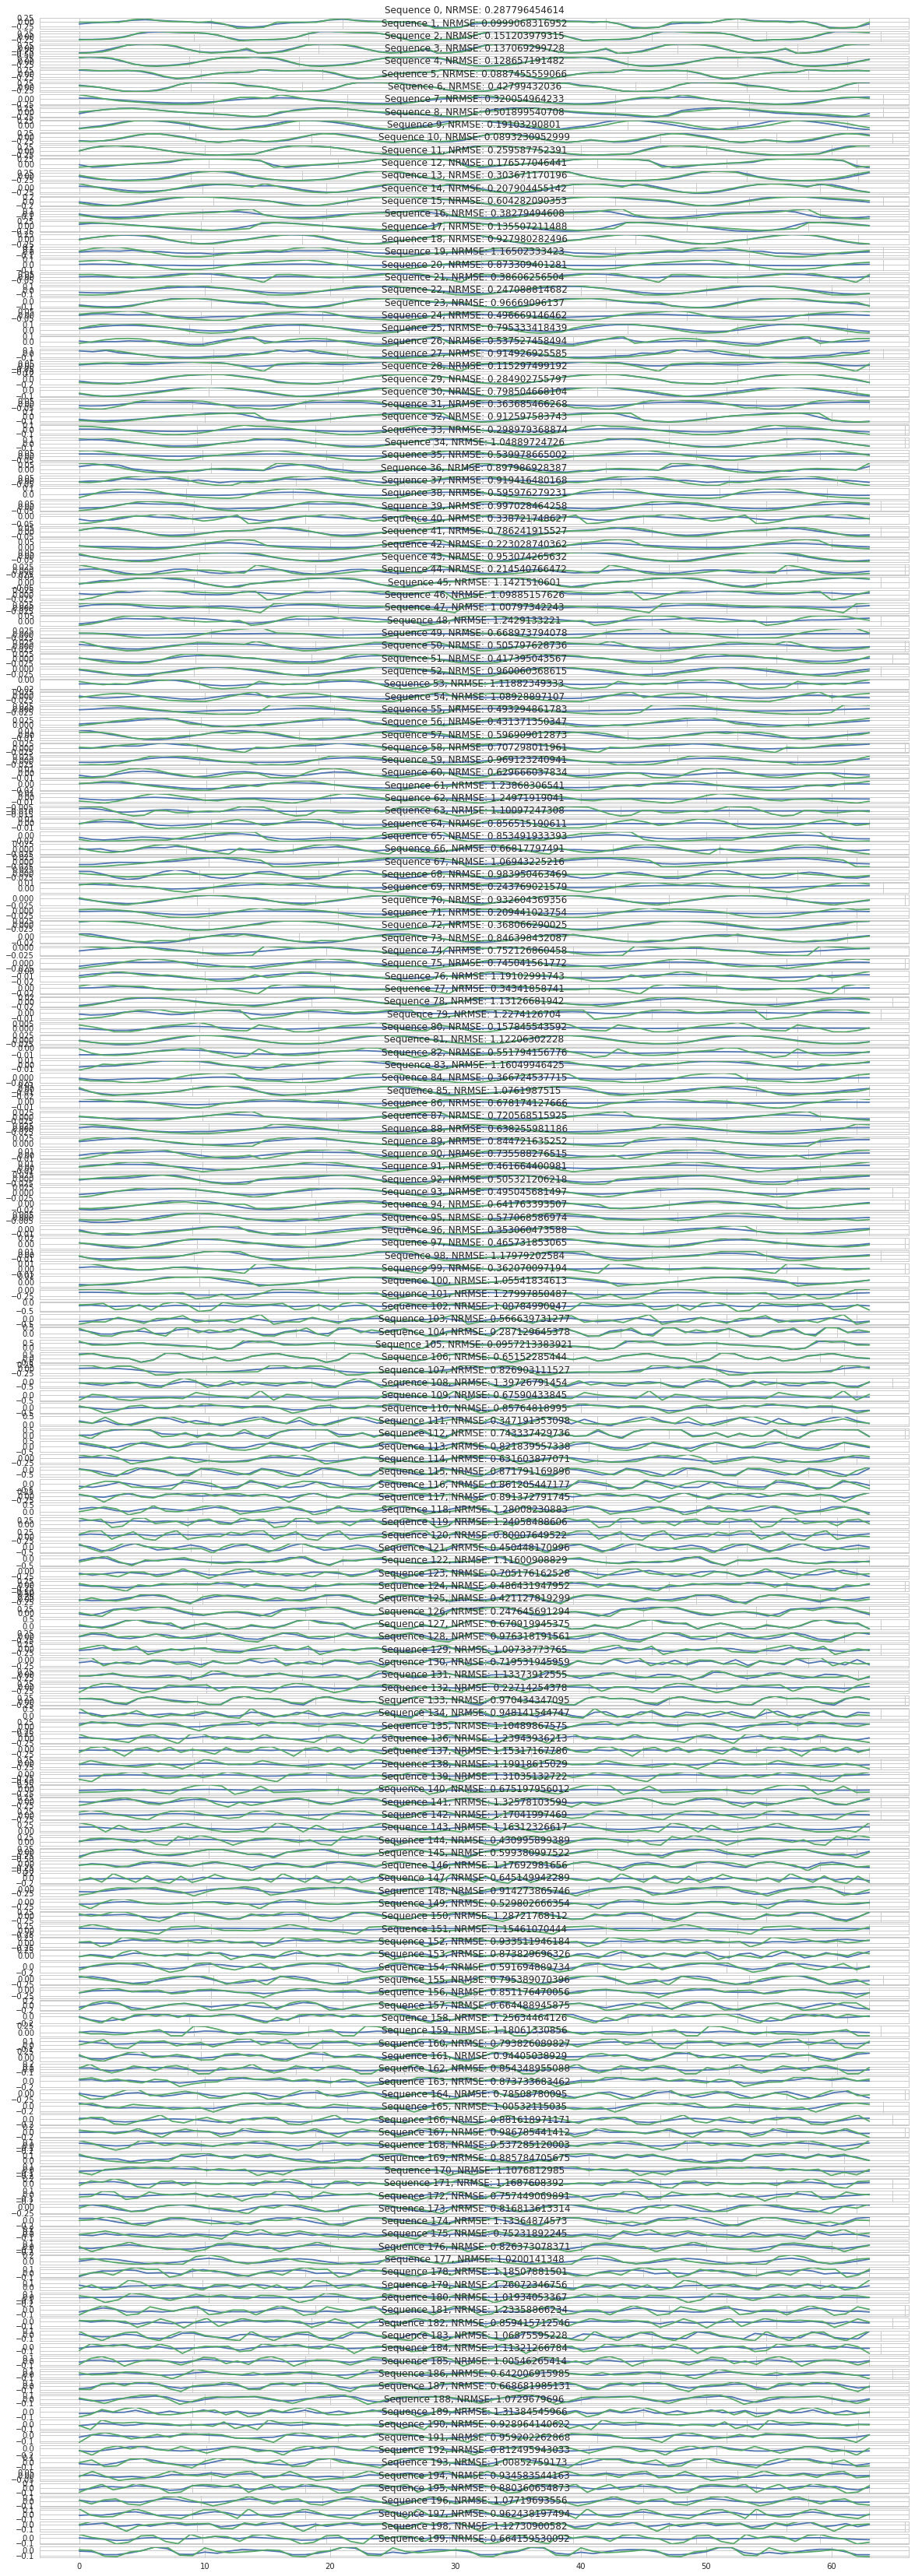

In [16]:
def plotConceptorPattern(net, cs, recallTestLength, i_pattern):
    x_CTestPL = np.zeros((net['p']['N'], recallTestLength, net['p']['patts'].shape[0]))
    z_CTestPL = np.zeros((net['p']['N'], recallTestLength, net['p']['patts'].shape[0]))
    p_CTestPL = np.zeros((1, recallTestLength, net['p']['patts'].shape[0]))
    C = cs[0]
    x = 0.5 * np.random.randn(net['p']['N'],1) * 0
    z = x
    for n in range(recallTestLength + net['p']['washoutLength']):
        xOld = x
        Wtarget = (net['W'].dot(x))
        z = ((1.0-net['p']['LR']) * xOld) + (net['p']['LR'] * tanh(Wtarget + net['Wbias']))
        x = C.dot(z)
        xPrev = x
        if (n > net['p']['washoutLength']):
            x_CTestPL[:,n-net['p']['washoutLength'],i_pattern] = x.T
            z_CTestPL[:,n-net['p']['washoutLength'],i_pattern] = z.T
            p_CTestPL[:,n-net['p']['washoutLength'],i_pattern] = net['Wout'].dot(np.concatenate((x[:,0], np.array([1]))))
    
    outputPattern = p_CTestPL[:,:,i_pattern][0]
    targetPattern = np.array([net['p']['patts'][i_pattern].take(x, mode='wrap') for x in arange(recallTestLength)])
    templateScan = np.correlate(outputPattern[:net['p']['patts'][i_pattern].size*2],net['p']['patts'][i_pattern])
    matchPoint = np.argmax(templateScan)
    if (matchPoint > 0):
        outputPattern = outputPattern[matchPoint:]
        targetPattern = targetPattern[:-matchPoint]
    score = nrmse(outputPattern, targetPattern) 
    print(score)
    plot(outputPattern)
    plot(targetPattern)
    return score
    
    
figsize(20,60)
patternCs = np.zeros(len(apertures), dtype=np.object)
scores = np.zeros(len(apertures))
for i_patt in range(len(apertures)):
    print(i_patt)
    ax = subplot(len(apertures), 1, i_patt+1)
    patternCs[i_patt] = computeConceptor(loadedNets[bestNetwork], i_patt, apertures[i_patt])
    scores[i_patt] = plotConceptorPattern(loadedNets[bestNetwork], patternCs[i_patt], windowSize * 5, i_patt)
    ax.set_title("Sequence " + str(i_patt) + ", NRMSE: " + str(scores[i_patt]))
plt.savefig("/tmp/tests.pdf")

0.768532575156
[ 0.28779645  0.09990683  0.15120398  0.1370693   0.12865719  0.08874556
  0.42799432  0.32005496  0.50189954  0.19103291  0.0893231   0.25958775
  0.17657705  0.30367117  0.20790446  0.60428209  0.38279495  0.13550721
  0.92798028  1.16502333  0.8733094   0.38606257  0.24708881  0.96669096
  0.49666915  0.79533342  0.53752746  0.91492693  0.1152975   0.28490276
  0.79850467  0.36368547  0.91259758  0.29897937  1.04889725  0.53997867
  0.89798693  0.91941648  0.59597628  0.99702846  0.33872175  0.78624192
  0.22302874  0.95307427  0.21454077  1.14215106  1.09885158  1.00797342
  1.24291332  0.66897379  0.50579763  0.41739504  0.96006037  1.11882349
  1.08928897  0.49329486  0.43137135  0.59690901  0.70729801  0.96912324
  0.62966604  1.23868307  1.24971919  1.10097247  0.85651519  0.85349193
  0.66817797  1.06943225  0.98395046  0.24376902  0.93260437  0.20944102
  0.36806629  0.84639843  0.75212686  0.74504156  1.19102992  0.34341859
  1.13126682  1.22741267  0.15784554

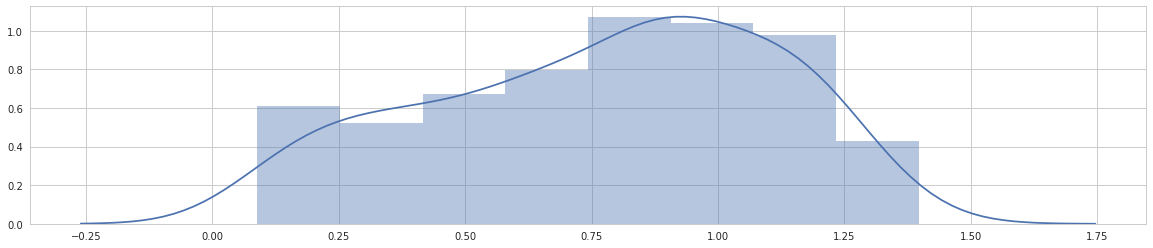

In [17]:
print(np.mean(scores))
print(scores)
figsize(20,4)
# plot(sort(scores))
print(sort(scores))
# print(median(scores))
sns.distplot(scores)
# plt.savefig("/tmp/scoresDistrib.pdf")

In [18]:
sys.getsizeof(patternCs[0][0]) / 1048576 * 200

976.5838623046875

In [49]:
%%time

def render(net, pcs, cMod=1.0, lrMod=1.0, alphaMod=1.0, speed=1.0, initScale=0.5):
    speed = 1.0/speed
    audio = np.zeros(0)
    x = initScale * np.random.randn(net['p']['N'],1)
    C = pcs[0][0]
    LR = net['p']['LR'] * lrMod
    orgW = net['W']
    Wmod = orgW * alphaMod
    #run to washout
    for n in range(net['p']['washoutLength']):
        xOld = x
        Wtarget = (net['W'].dot(x))
        z = ((1.0-net['p']['LR']) * xOld) + (net['p']['LR'] * tanh(Wtarget + net['Wbias']))
        x = C.dot(z)
        
    for n in range(int(windowSize * pcs.shape[0] * abs(speed))):
        currConceptor = int(n/abs(speed) / windowSize)
        if (speed <= 0):
            currConceptor = pcs.shape[0] - currConceptor - 1  #reverse
        C = pcs[currConceptor][0] * cMod
        xOld = x
        Wtarget = (Wmod.dot(x))
        z = ((1.0 - LR) * xOld) + (LR * tanh(Wtarget + net['Wbias']))
        x = C.dot(z)
        newSample = net['Wout'].dot(np.concatenate((x[:,0], np.array([1]))))
        audio = np.concatenate((audio, newSample))
    return audio



CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.01 µs


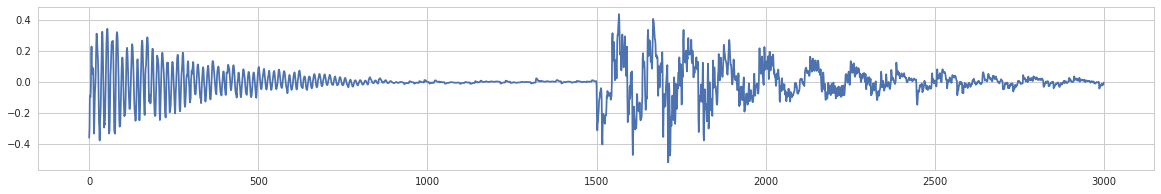

In [20]:

figsize(20,3)
audio = render(loadedNets[bestNetwork], patternCs, 1.0, 1.0, 1, 1)
plot(audio)
# plt.savefig('/tmp/recon.pdf')
Audio(data=audio,rate=sr)


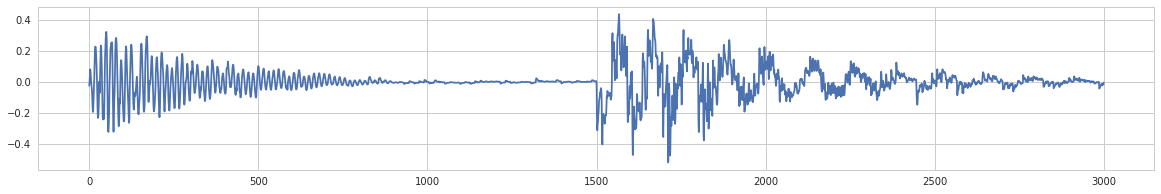

In [21]:

figsize(20,3)
audio = render(loadedNets[bestNetwork], patternCs, cMod=1.0, lrMod=1.0, alphaMod=1.0, speed=1.0)
plot(audio)
Audio(data=audio,rate=sr)

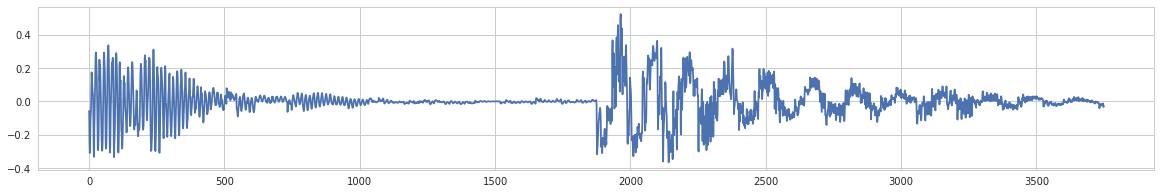

In [22]:

figsize(20,3)
audio2 = render(loadedNets[bestNetwork], patternCs, cMod=1.0, lrMod=1.0, alphaMod=1.0, speed=0.8)
plot(audio2)
Audio(data=audio2,rate=sr)

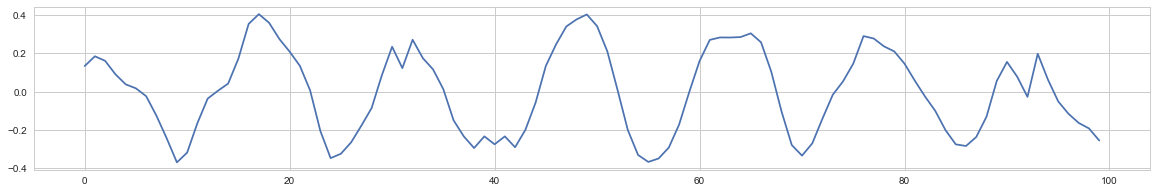

In [30]:
plot(audio[:100])

In [24]:
# import dill as pickle
# model = {"net":loadedNets[bestNetwork], "Cs":patternCs}
# with open(r"models/expt1SnareBongoModel.pickled", "wb") as output_file:    
#     pickle.dump(model, output_file, protocol=0)

In [2]:
#load a saved model
# import dill as pickle
# with open(r"models/expt1SnareBongoModel.pickled", "rb") as in_file:    
#     model = pickle.load(in_file)

In [23]:
pattMix = np.zeros_like(model['Cs'][:100])
mix = 0.1
invmix = 1-mix
for i in range(100):
    pattMix[i] = (model['Cs'][i] * mix) + (model['Cs'][i+100] * invmix)

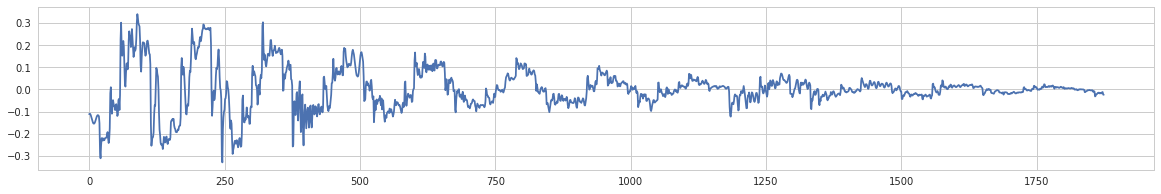

In [24]:

figsize(20,3)
audio2 = render(model['net'], pattMix, cMod=1.0, lrMod=1.0, alphaMod=1.0, speed=0.8)
plot(audio2)
Audio(data=audio2,rate=sr)

0,1,2,3,4,5,6,7,8,9,10,

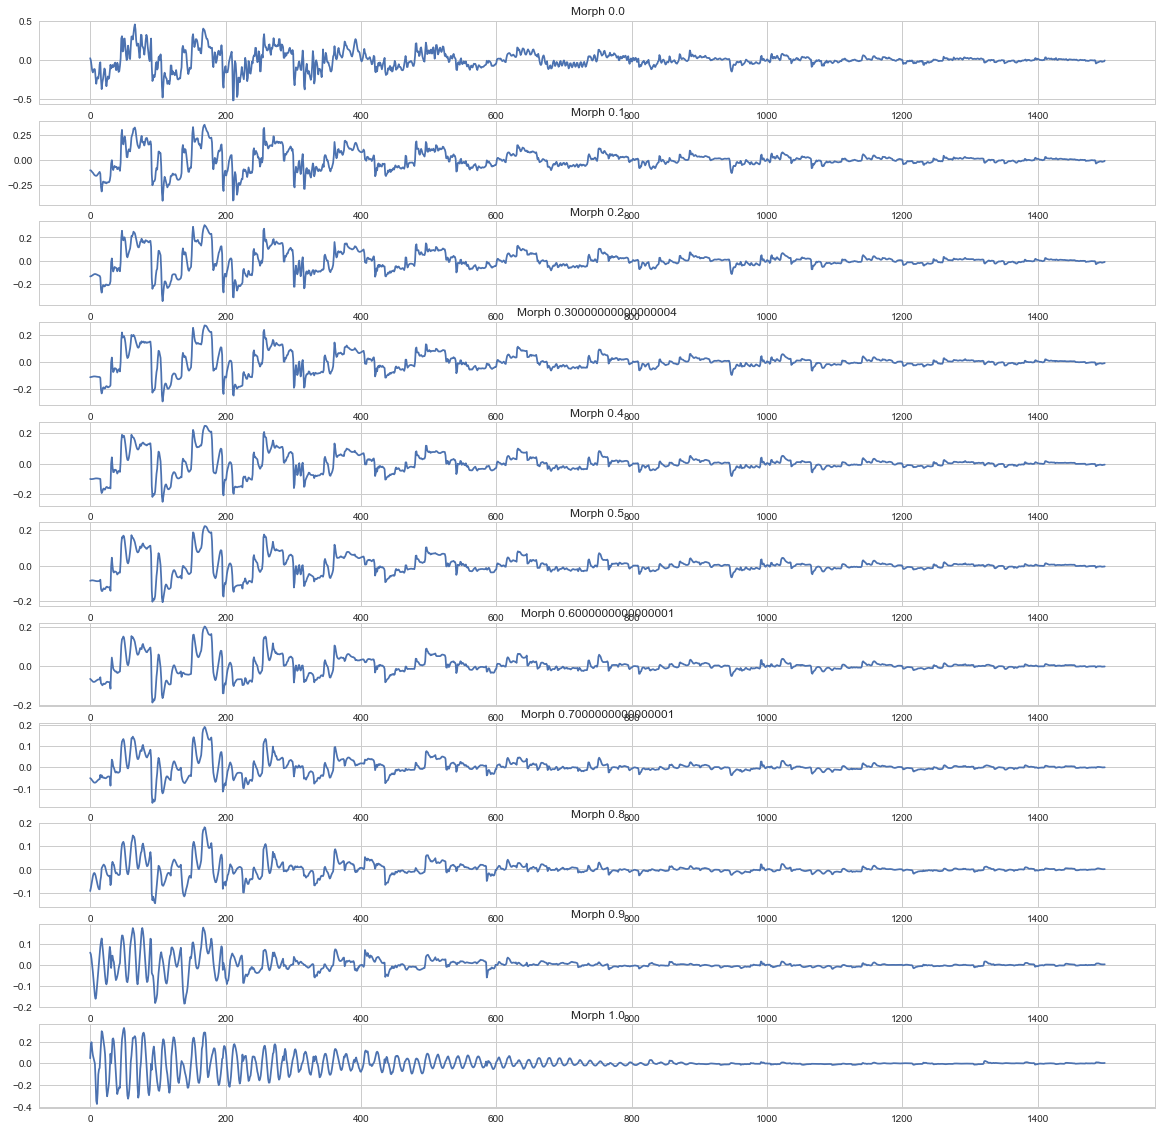

In [28]:
figsize(20,20)
recording = np.array([])
for i_sample in range(11):
    print(str(i_sample) + ",", end='')
    pattMix = np.zeros_like(model['Cs'][:100])
    mix = i_sample*0.1
    invmix = 1-mix
    for i in range(100):
        pattMix[i] = (model['Cs'][i] * mix) + (model['Cs'][i+100] * invmix)    
    audio2 = render(model['net'], pattMix, cMod=1.0, lrMod=1.0, alphaMod=1.0, speed=1.0)
    ax = subplot(11, 1, i_sample+1)
    plot(audio2)
    recording = np.concatenate((recording, audio2, np.zeros(1500)))
    ax.set_title("Morph " + str(mix))
# plt.savefig("Supplemental/Supplemental Figure S2.pdf")
    

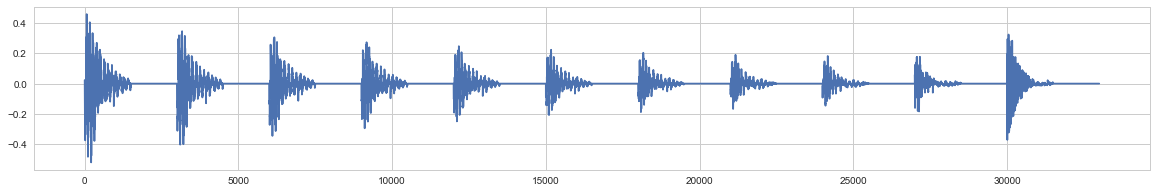

In [29]:
figsize(20,3)
plot(recording)
librosa.output.write_wav("results/morphing/snareBongoMorph.wav", recording, sr)

Audio(data=recording,rate=sr)

0,1,2,3,4,5,6,7,8,9,10,

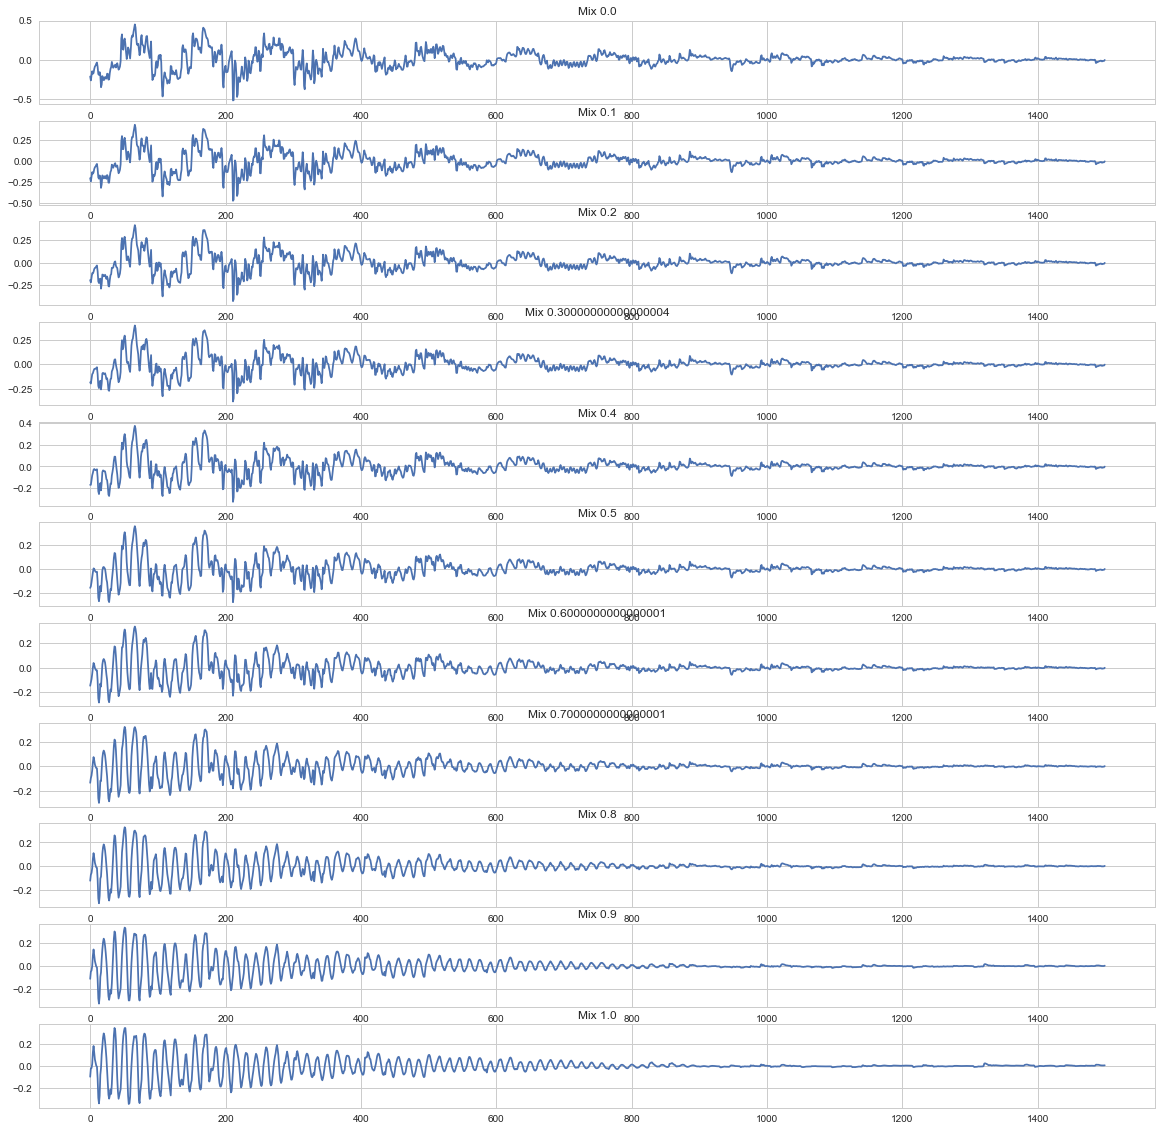

In [32]:
#compare to mixing
figsize(20,20)
recording = np.array([])
snare = render(model['net'], model['Cs'][100:], cMod=1.0, lrMod=1.0, alphaMod=1.0, speed=1.0)
bongo = render(model['net'], model['Cs'][:100], cMod=1.0, lrMod=1.0, alphaMod=1.0, speed=1.0)
for i_sample in range(11):
    print(str(i_sample) + ",", end='')
    pattMix = np.zeros_like(model['Cs'][:100])
    mix = i_sample*0.1
    invmix = 1-mix
    audio2 = (bongo * mix) + (snare * invmix)
    ax = subplot(11, 1, i_sample+1)
    plot(audio2)
    recording = np.concatenate((recording, audio2, np.zeros(1500)))
    ax.set_title("Mix " + str(mix))
plt.savefig("Supplemental/Supplemental Figure S3.pdf")

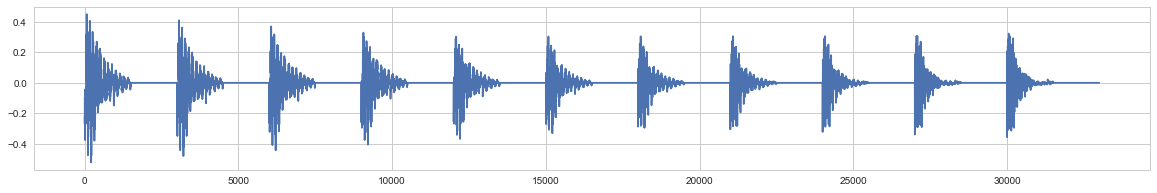

In [31]:
figsize(20,3)
plot(recording)
librosa.output.write_wav("results/morphing/snareBongoLinearMix.wav", recording, sr)

Audio(data=recording,rate=sr)

In [ ]:
pattMix = np.zeros_like(model['Cs'][:100])
mix = 0.5
invmix = 1-mix
for i in range(100):
    pattMix[i] = (model['Cs'][i] * mix) + (model['Cs'][i+100] * invmix)

In [25]:
def conceptorAnd(C1, C2):
    return linalg.inv(linalg.inv(C1) + linalg.inv(C2) - np.eye(C1.shape[0]))

def conceptorOr(C1, C2):
    I = np.eye(C1.shape[0])
    x1 = C1.dot(linalg.inv(I - C1))
    x2 = C2.dot(linalg.inv(I - C2))
    return linalg.inv(I + linalg.inv(x1 + x2))

def conceptorNot(C1):
    return 1 - C1

In [72]:
import copy

cset = copy.deepcopy(model['Cs'][:100])
for i in range(100):
    print(i, end=",")
    cset[i][0] = conceptorOr(model['Cs'][i][0], model['Cs'][100+i][0])

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,

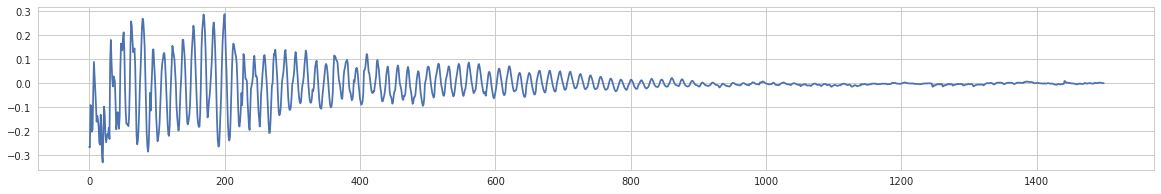

In [73]:
figsize(20,3)
audio = render(model['net'], cset, lrMod=1.0, alphaMod=1.0, speed=1.0)
plot(audio)
Audio(data=audio,rate=sr)

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,

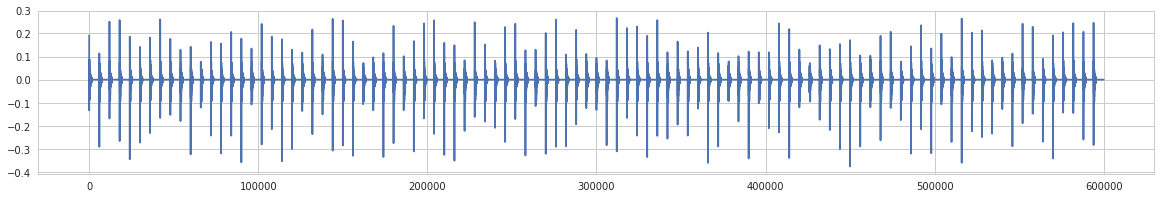

In [68]:
figsize(20,3)
testCount=100
renders = np.empty((testCount,audio.size))
recording = np.array([])
for i_sample in range(testCount):
    print(i_sample, end=",")
    audio = render(model['net'], cset, lrMod=1.0, alphaMod=1.0, speed=1, initScale=0.5)
    recording = np.concatenate((recording, audio, np.zeros(1500*3)))
    renders[i_sample] = audio
plot(recording)
Audio(data=recording,rate=sr)

/home/chrisk/env3/lib/python3.5/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


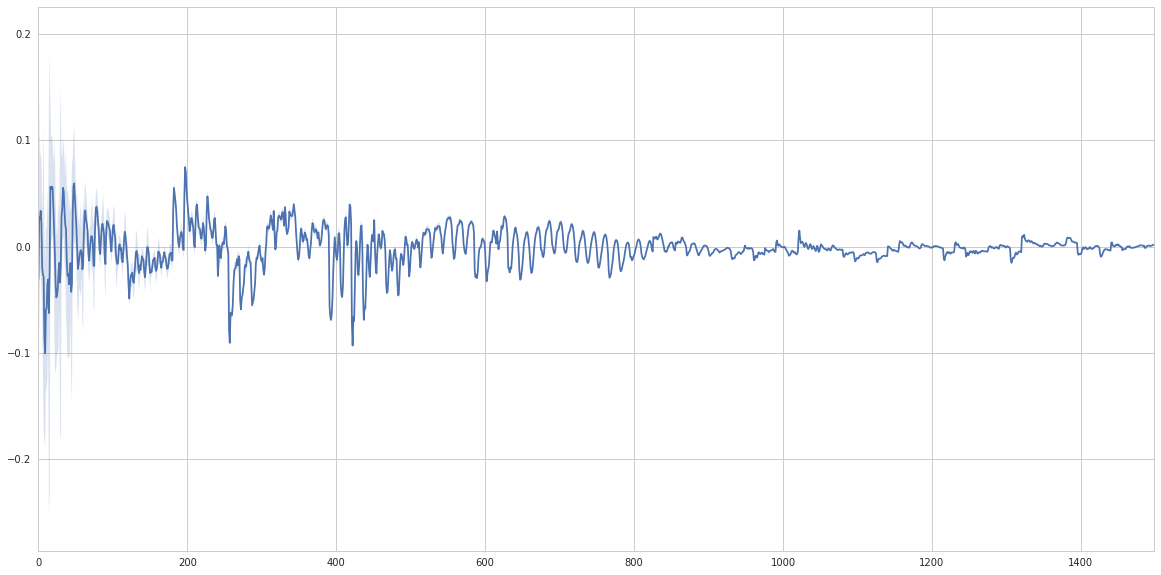

In [70]:
figsize(20,10)
sns.tsplot(renders[:,:], ci="sd")

In [59]:
cset = copy.deepcopy(model['Cs'][:100])
Call = copy.deepcopy(cset[0][0])
for i in range(200-1):
    print(i, end=",")
    Call = conceptorOr(Call, model['Cs'][(i+1) % 200][0])

for i in range(100):
    cset[i][0] = Call

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,

0,1,2,3,4,5,6,7,8,9,

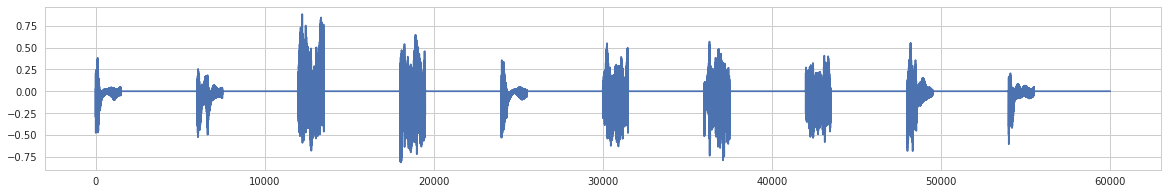

In [60]:
figsize(20,3)
testCount=10
renders = np.empty((testCount,audio.size))
recording = np.array([])
for i_sample in range(testCount):
    print(i_sample, end=",")
    audio = render(model['net'], cset, lrMod=1.0, alphaMod=1.0, speed=1, initScale=0.5)
    recording = np.concatenate((recording, audio, np.zeros(1500*3)))
    renders[i_sample] = audio
plot(recording)
Audio(data=recording,rate=sr)